In [1]:
from modelData import ModelData
from boltz.boltzmannEq import boltz, computeCollisionTerms,computeDecayTerms
from scipy.integrate import solve_ivp,odeint
import numpy as np
from matplotlib import pyplot as plt
from tools.configParserWrapper import ConfigParserExt
import os
from tools.logger import setLogLevel

### Load input parameters

In [2]:
parfile = './input_parameters.ini'
parser = ConfigParserExt(inline_comment_prefixes="#")   
ret = parser.read(parfile)
parser = parser.expandLoops()[0]
parserDict = parser.toDict(raw=False)

In [3]:
pars = parser['SolverParameters']
atol = pars['atol']
rtol = pars['rtol']
T0 = pars['T0']
Tf = pars['Tf']
method = pars['method']
nsteps = pars['nsteps']
outputFolder = os.path.abspath(parser['Options']['outputFolder'])
paramCard = os.path.join(outputFolder,'Cards','param_card.dat')
sigmaVFile = os.path.join(outputFolder,'output','taacs.csv')
dm = parser['Model']['darkmatter']
bsmList = []
if 'bsmParticles' in parser['Model']:
    bsmList = str(parser['Model']['bsmParticles']).split(',')
model = ModelData(dmPDG=dm, bsmPDGList=bsmList, paramCard=paramCard, sigmaVfile=sigmaVFile)
    

compDict = model.componentsDict
mDM = compDict[model.dmPDG].mass
x0 = mDM/T0
xf = mDM/Tf    


In [4]:
# Set initila conditions
initialCond = pars['initialConditions']    
y0 = np.zeros(len(model.componentsDict))
for label,comp_y0 in initialCond.items():
    pdg = model.convert2PDG(label)
    comp = compDict[pdg]
    if isinstance(comp_y0,float):
        y0[comp.ID] = y0
    elif comp_y0.lower() in ['eq', 'equilibrium']:
        y0[comp.ID] = comp.Yeq(T0)
    
xvals = np.linspace(x0,xf,nsteps)

In [5]:
# Initial conditions
x0, xf = 0.1,5.0
setLogLevel('info')

### Check terms in initial conditions

In [6]:
for comp in compDict.values():
    print(comp,y0[comp.ID],comp.Yeq(mDM/x0))

SM 0.0 0.2776566338315371
xd 0.007802996735312518 0.007802996735312518


In [7]:
coll = computeCollisionTerms(x0,y0,model)
dec = computeDecayTerms(x0,y0,model)
print(coll)
print(dec)

[{}, {'xdxdx_bbx': np.float64(-6.418737385366042e-26), 'xdxdx_ttx': np.float64(-6.418737385366042e-26)}]
[[0. 0.]
 [0. 0.]]


In [8]:
for process in model.collisionProcesses:
    sigma = process.sigmaV(x0)
    print(f'Process {process.name} : sigmav = {sigma}')

Process xdxdx_bbx : sigmav = 1.0542090909090905e-21
Process xdxdx_ttx : sigmav = 1.0542090909090905e-21
Process xdxdx_b1b1x : sigmav = 0.0
Process b1xd_gb : sigmav = -4.003000000000014e-16
Process b1xxdx_gbx : sigmav = -4.003000000000014e-16
Process b1xd_ab : sigmav = -4.003000000000014e-16
Process b1xxdx_abx : sigmav = -4.003000000000014e-16
Process b1xd_bz : sigmav = -4.003000000000014e-16
Process b1xxdx_bxz : sigmav = -4.003000000000014e-16
Process b1xd_twm : sigmav = -4.003000000000014e-16
Process b1xxdx_txwp : sigmav = -4.003000000000014e-16
Process b1b1x_bbx : sigmav = 9.68227272727273e-10
Process b1b1_bb : sigmav = 9.68227272727273e-10
Process b1xb1x_bxbx : sigmav = 9.68227272727273e-10
Process b1b1x_gg : sigmav = 9.68227272727273e-10
Process b1b1x_wpwm : sigmav = 9.68227272727273e-10
Process b1b1x_ga : sigmav = 9.68227272727273e-10
Process b1b1x_gz : sigmav = 9.68227272727273e-10
Process b1b1x_aa : sigmav = 9.68227272727273e-10
Process b1b1x_az : sigmav = 9.68227272727273e-10
P

### Solve equations

In [ ]:
xvals = np.linspace(x0,xf,100)
#solving the Boltzmann equation
# sol = solve_ivp(boltz, [x0,xf], y0, args=(model,), atol = atol, rtol = rtol, method='BDF')
Yf_sol = [y0]
for x in xvals[1:]:
    Yf_sol.append(solve_ivp(boltz, [x0,x], y0, args=(model,), atol = atol, rtol = rtol, method='BDF').y[-1])
    y0 = Yf_sol[-1]
    x0 = x
# Yf_sol = np.array(Yf_sol).transpose()

# from scipy import integrate
# ode15s = integrate.ode(boltz)
# ode15s.set_integrator('vode', method='bdf', order=15)
# ode15s.set_initial_value(y0, x0)
# ode15s.set_f_params(model)

# Yf_sol = [y0]

# for x in xvals[1:]:
#     print(x)
#     Yf_sol.append(ode15s.integrate(x))
# Yf_sol = np.array(Yf_sol).transpose()

/home/lessa/BoltzmannEqs/boltz/boltzmannEq.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  Yratio[comp.ID] = Y[comp.ID]/comp.Yeq(T)
/home/lessa/BoltzmannEqs/boltz/boltzmannEq.py:81: RuntimeWarning: overflow encountered in scalar multiply
  r = Yratio[c]*Yratio[d]/(Yratio[a]*Yratio[b])


In [10]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e-01  1.000e-01 ...  4.980e+00  5.000e+00]
        y: [[ 2.777e-01  2.777e-01 ...  2.777e-01  2.777e-01]
            [ 7.803e-03  7.803e-03 ... -1.022e+07 -1.023e+07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 962
     njev: 42
      nlu: 142

In [12]:
sol.y.shape
# Yf_sol.shape

(2, 318)

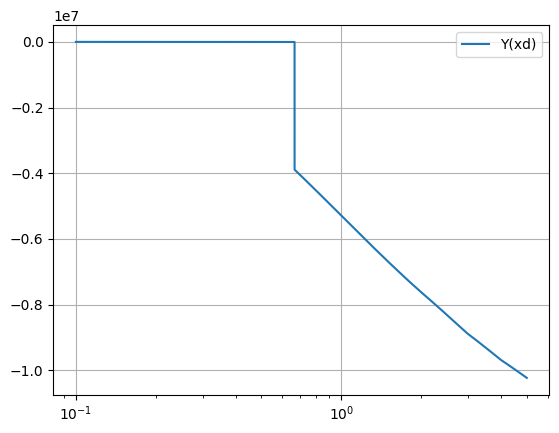

In [13]:
for comp in compDict.values():
    if comp.ID == 0: continue
    plt.plot(sol.t,sol.y[comp.ID,:],label=f'Y({comp.label})')
    # plt.plot(xvals,Yf_sol[comp.ID,:],label=f'Y({comp.label})')

plt.legend()
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-4,10)
plt.grid()
# plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

In [ ]:
Yf_sol[2,:]

IndexError: index 2 is out of bounds for axis 0 with size 2